<h1> Satellite Precipitation Data Analysis</h1>

<p> This project's goal is to analyze PERSIANN (Precipitation Estimation from Remotely Sensed Information using Artificial Neural Networks) 
dataset provided by CHRS Data Portal. </p>

<h2>Exploring the data</h2>

In [13]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
example_satellite_image_path = "./data/PERSIANN_6h2019011706.tif"

example_img = np.asarray(Image.open(example_satellite_image_path))
print("Data (tiff image) shape:", example_img.shape)

Data (tiff image) shape: (25, 42)


In [ ]:
print("Data as array (row nr 10):", example_img[10])

In [ ]:
from matplotlib.colors import NoNorm
plt.imshow(example_img, cmap='gray', norm=NoNorm())

<h2>Loading the data</h2>

In [ ]:
import glob, os
import re
from datetime import datetime

data_path = "./data"
data_datetime_pattern = re.compile(r'^.*PERSIANN_6h(\d{10}).tif$')

def getDateTimeFromFileName(file_name):
    date_time_string = data_datetime_pattern.search(file_name).group(1)
    return datetime.strptime(date_time_string, '%Y%m%d%H')

def getTiffFileAsArray(file_name):
    return np.asarray(Image.open(file_name))

# get all files containing data
all_files = glob.glob(os.path.join(data_path, '*.tif'), recursive=False)

# load data into array of tuples
data = [(getDateTimeFromFileName(f), getTiffFileAsArray(f)) for f in all_files]


# Display data

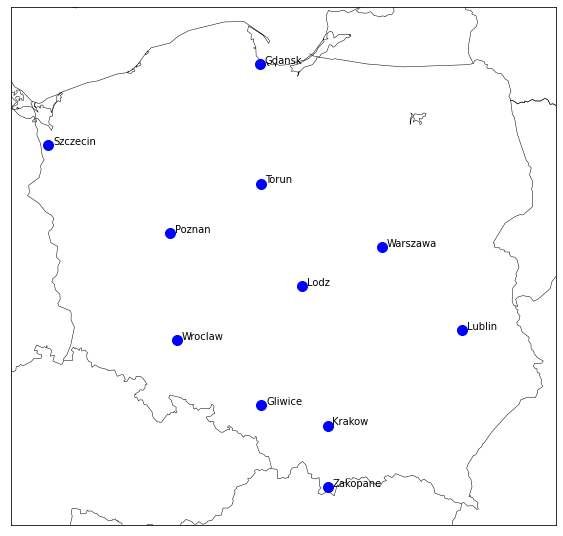

In [12]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np

#data = np.genfromtxt('20130418.txt', names=True, delimiter=',')
#lats = data['lat'].copy().reshape(813, 1051)
#lons = data['long'].copy().reshape(813, 1051)
#precip = data['value'].copy().reshape(813, 1051)
#precip_in = np.ma.masked_less(precip, 0.01)

miasta = {
    'Gdansk': {'pos': (54.36, 18.64)},
    'Gliwice': {'pos': (50.31, 18.67)},
    'Krakow': {'pos': (50.06, 19.96)},
    'Lodz': {'pos': (51.77, 19.46)},
    'Lublin': {'pos': (51.24, 22.57)},
    'Poznan': {'pos': (52.4, 16.9)},
    'Szczecin': {'pos': (53.43, 14.53)},
    'Torun': {'pos': (52.9823, 18.6552)},
    'Wroclaw': {'pos': (51.11, 17.03)},
    'Zakopane': {'pos': (49.29, 19.96)},
    'Warszawa': {'pos': ( 52.2297700, 21.0117800 )},
}

def plot_conus():
    # zakres mapy (Polska)
    lat_min, lat_max = 48.8, 55.0
    lon_min, lon_max = 13.8, 24.4

    # wymiary rysunku
    fig = plt.figure(figsize=(10.0, 9.0))

    # marginesy
    plt.subplots_adjust(left=0.10, right=0.90, top=0.90, bottom=0.10, wspace=0.15, hspace=0.05)
    m = Basemap(
        resolution='i',
        projection='merc',
        llcrnrlat=lat_min,
        urcrnrlat=lat_max,
        llcrnrlon=lon_min,
        urcrnrlon=lon_max)
    m.drawcountries(linewidth=0.5)
    m.drawcoastlines(linewidth=0.5)
    
    # rysowanie miast
    for nazwa, dane in miasta.items():
        # współrzędne w odwrotnej kolejności
        x, y = m(dane['pos'][1], dane['pos'][0])

        # narysowanie symbolu
        m.plot(x, y, 'bo', markersize=10)

        # wypisanie etykiety (z przesunięciem)
        plt.text(x + 10000, y + 1000, nazwa)
    
    return m


plot_conus()